
![airline_delays](https://miro.medium.com/max/1180/1*7pKBn-RXnqvrl-joQgMwZw.jpeg)

# Airline Delays
**Dataset Case Study**
The data used will be taken from Kaggle's datasets **Airlines Delay** found at [Kaggle](https://www.kaggle.com/giovamata/airlinedelaycauses) by [Giovanni Gonzalez](https://www.kaggle.com/giovamata)

# 1. Data preparation
In order to analyze the data, the dataset first has to be processed, cleaned and polished.

## 1.1. Imports
Python libraries

In [106]:
import pandas as pd
import os
!pip install kaggle --upgrade --quiet
import seaborn as sns
sns.set_theme(style="darkgrid")
os.getcwd()

'/home/noone/data-exercises/kaggle-airline-df'

## 1.2. Project folder structure
Let's do a simple folder structure in order to organize all the working data.

| root
|--- kaggle-airline-df
|---|--- input

In [11]:
# Prepare directories
root = os.getcwd()

# Change working directory
if "kaggle-airline-df" in root:
    wd_dir = root
else:
    wd_dir = os.path.join(root,"kaggle-airline-df")
    os.mkdir(wd_dir)
    os.chdir(wd_dir)

## 1.3. Download the dataset
Using Kaggle's API, download the entire dataset

In [12]:
# Download the dataset using Kaggle's API
dataset_dir = os.path.join(wd_dir,"input")

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)
    os.chdir(dataset_dir)
    !kaggle datasets download giovamata/airlinedelaycauses
    !unzip airlinedelaycauses.zip
    !rm airlinedelaycauses.zip

# Return to the main directory
os.chdir(wd_dir)

# 2. Dataset
Load the dataset to perform exploration, cleaning, rearranging and imputation.

## 2.1. Loading the dataset
Previewing the dataset and then loading it full

In [13]:
# Load only the column names from the CSV file
file_name = "input/DelayedFlights.csv"
col_names = pd.read_csv(file_name, nrows=1).columns.tolist()
print(col_names)

['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


In [14]:
# Let's list the undesired columns
undesired_cols_indices = ["CancellationCode"]
# Remove them from the col_names
dummy = [col_names.remove(undesired) for undesired in undesired_cols_indices]

In [89]:
# Now load the CSV data file with only the desired data, using the first column as index.
# The index usually does not have any name, maybe because of that the shown name is "Unnamed:0"
df = pd.read_csv(file_name, usecols=col_names, index_col=0)
# Let's take a look
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,810,4.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,810,5.0,10.0,0,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,515,3.0,17.0,0,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,515,3.0,10.0,0,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,688,4.0,10.0,0,0,NaN,NaN,NaN,NaN,NaN


## 2.2. Cleaning
Fix data types and dates

In [81]:
# Let's check the actual datatypes associated to each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       float64
 24  WeatherDelay       float64
 25  NASDelay          

In [96]:
# Are there NaNs?
nans = df.isna().sum().sum()
print(f'There are {nans} NaNs')

There are 3486389 NaNs


In [98]:
# The NaNs detected are observations of value zero, so let's substitute them with proper 0s
df.fillna(value=0,inplace=True)

# Now, all the variables in the dataset that are not strings should be represented without decimals.
# So they can be converted into integer dtype
df = df.select_dtypes(exclude=[object]).astype("int")

In [99]:
# The first columns are daily data separated by some non standard rule. Let's convert them into date datatype.
convert_dict = {
    "Year": str,
    "Month": str,
    "DayofMonth": str
}
df = df.astype(convert_dict) # Convert to string

df["Date"] = df["Year"] + "/" + df["Month"] + "/" + df["DayofMonth"]
df["Date"] = pd.to_datetime(df["Date"],format="%Y/%m/%d")

# Now drop the columns
df.drop(columns=["Year","Month","DayofMonth"],inplace=True)

In [104]:
df.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,...,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date
0,4,2003,1955,2211,2225,335,128,150,116,-14,...,4,8,0,0,0,0,0,0,0,2008-01-03
1,4,754,735,1002,1000,3231,128,145,113,2,...,5,10,0,0,0,0,0,0,0,2008-01-03
2,4,628,620,804,750,448,96,90,76,14,...,3,17,0,0,0,0,0,0,0,2008-01-03
4,4,1829,1755,1959,1925,3920,90,90,77,34,...,3,10,0,0,2,0,0,0,32,2008-01-03
5,4,1940,1915,2121,2110,378,101,115,87,11,...,4,10,0,0,0,0,0,0,0,2008-01-03


<AxesSubplot:xlabel='Date', ylabel='ArrDelay'>

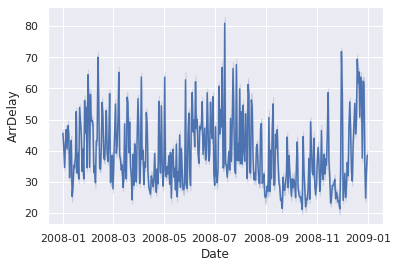

In [107]:
sns.lineplot(x="Date",y="ArrDelay",data=df)

In [110]:
df.to_csv("data-clean.csv", index=False)

In [111]:
df2 = pd.read_csv("data-clean.csv")
df2.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,...,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date
0,4,2003,1955,2211,2225,335,128,150,116,-14,...,4,8,0,0,0,0,0,0,0,2008-01-03
1,4,754,735,1002,1000,3231,128,145,113,2,...,5,10,0,0,0,0,0,0,0,2008-01-03
2,4,628,620,804,750,448,96,90,76,14,...,3,17,0,0,0,0,0,0,0,2008-01-03
3,4,1829,1755,1959,1925,3920,90,90,77,34,...,3,10,0,0,2,0,0,0,32,2008-01-03
4,4,1940,1915,2121,2110,378,101,115,87,11,...,4,10,0,0,0,0,0,0,0,2008-01-03
